# Rodrigo Barraza's Inscriptions: Blip 2 Mass Captioning
Large RAM and VRAM is required to load the larger models. RAM should be at least 24-32GB with 64GB being optimal. VRAM should be at least 16GB or more.

In [ ]:
# !pip3 install transformers
# !pip install pillow
# !pip install requests
# !pip install validators
# !pip install accelerate

In [ ]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer, Blip2Model
import torch
import sys
import validators

import os
import re
import time
from pathlib import Path
from collections import OrderedDict
from IPython.display import clear_output
from PIL import Image


# from lavis.models import load_model_and_preprocess

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Salesforce/blip2-opt-2.7b
# Salesforce/blip2-opt-2.7b-coco
# Salesforce/blip2-opt-6.7b
# Salesforce/blip2-opt-6.7b-coco
# Salesforce/blip2-flan-t5-xl
# Salesforce/blip2-flan-t5-xl-coco
# /Salesforce/blip2-flan-t5-xxl

tokenizer = AutoTokenizer.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco",
    add_prefix_space=True) # Required to use bad_words_ids
processor = Blip2Processor.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-6.7b-coco",
    device_map='auto',
    # load_in_8bit=True)
    torch_dtype=torch.float16)

🌐 Total Dataset size: 40224
📪 Caption: product photography, productphotodaily, a can of red bull on a green background, summer
🔎 Processed images: 574/1907 (30.1%)
🌎 Remaining images: 1333
⚡ Recaptioned: 484 times
⏳ Estimated time remaining: 00:41:11


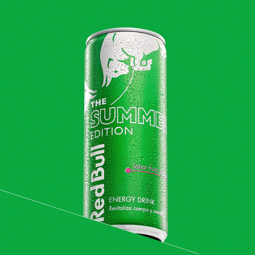

In [6]:
###############################################################################
# Start of Options

imagesDirectory = r"/mnt/d/dataset-1080-new"
addFolderNamesToCaptions = True  # Append the folder names to the beginning of the caption
folderNamesAtStartOrEnd = 'start'  # end or start
enableOverwritingExistingCaptions = False  # Overwrite existing captions
enableExtraDescriptors = True

# PRINT OPTIONS
showCurrentImage = True
showCaption = True
showRecaptionedImages = True
showProcessedImages = True
showRemainingImages = True
clearOutput = True

# PREPROCESSOR SETTINGS
skipSpecialTokens = True

# MODEL GENERATION SETTINGS
useNucleusSampling = False
numberOfBeams = 3  # The number of beams to use for beam search
lengthPenalty = 1
minTokenLength = 5  # The amount of minimum tokens to generate
maxTokenLength = 72  # The maximum amount of tokens to generate
repetitionPenalty = 1
topP = 0.9
temperature = 1.0

# TOKENIZER SETTINGS
# enableForceWords = False
# forceWordsList = ["water"]
# removeBadWords = False
# badWordsList = ["teddy bear"]
# padding = True
# add_special_tokens = False

# End of Options
###############################################################################

forceWordsIds = None
badWordsIds = None
primaryCaptionTokenLength = 0

# Count the total number of images in the directory and subdirectories
totalImages = 0
processedImages = 0
recaptionedImages = 0

def generateCaption(rawImage, beams=numberOfBeams):
    global forceWordsIds
    global badWordsIds
    global recaptionedImages
    generatedCaption = ''

    # if enableForceWords:
    #     forceWords = tokenizer(
    #         forceWordsList,
    #         padding=padding,
    #         add_special_tokens=add_special_tokens,
    #         return_tensors="pt").to(device).input_ids
    #     forceWordsIds = forceWords.tolist()  # Convert the tensor to a list of lists

    # if removeBadWords:
    #     badWords = tokenizer(
    #         badWordsList,
    #         padding=padding,
    #         add_special_tokens=add_special_tokens,
    #         return_tensors="pt").to(device).input_ids
    #     badWordsIds = badWords.tolist()  # Convert the tensor to a list of lists

    inputs = processor(images=rawImage, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        force_words_ids=forceWordsIds,
        bad_words_ids=badWordsIds,
        num_beams=beams,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    primaryCaptionTokenLength = torch.numel(generated_ids)
    # If token length is too long (because it's repeated words over and over), try again with different settings
    if primaryCaptionTokenLength >= 72:
        print("Recaptioning... ⚠️")
        recaptionedImages += 1
        generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        force_words_ids=forceWordsIds,
        bad_words_ids=badWordsIds,
        num_beams=10,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=1.5,
        length_penalty=-1,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    generatedCaption = generatedCaption[0].strip()
    # If token length is too long (because it's repeated words over and over), try again with different settings
    if "png" in generatedCaption or "download" in generatedCaption:
        print("Recaptioning... ⚠️")
        badWords = tokenizer(
            ['png', 'download'],
            padding=True,
            add_special_tokens=False,
            return_tensors="pt").to(device).input_ids
        badWordsIds = badWords.tolist()
        recaptionedImages += 1
        generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        force_words_ids=forceWordsIds,
        bad_words_ids=badWordsIds,
        num_beams=10,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=1.5,
        length_penalty=-1,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    generatedCaption = generatedCaption[0].strip()
    # If token contains repeated words around ' of a ' or ' of an ', try again with different settings
    regexPatterns = [
        r'\b(\w+)\b of a \b\1\b',
        r'\b(\w+)\b of an \b\1\b'
    ]
    if any(re.search(pattern, generatedCaption) for pattern in regexPatterns):
        print("Recaptioning... ⚠️")
        recaptionedImages += 1
        generated_ids = model.generate(
        **inputs,
        do_sample=useNucleusSampling,
        num_beams=9,
        max_length=maxTokenLength,
        min_length=minTokenLength,
        repetition_penalty=1.9,
        length_penalty=1,
        top_p=topP,
        temperature=1)
        generatedCaption = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
        generatedCaption = generatedCaption[0].strip()
        for pattern in regexPatterns:
            if re.search(pattern, generatedCaption):
                generatedCaption = re.sub(pattern, lambda match: ' '.join(match.group().split()[:-3]), generatedCaption)
    return cleanUpCaption(generatedCaption)

def generateFolderNamesAsTokens(dirpath, caption, imagePath):
    generatedCaption = caption
    directoryPaths = os.path.dirname(os.path.relpath(imagePath, dirpath))
    relpathParts = [part for part in directoryPaths.split(os.sep) if "_" not in part and part != "."]
    validParts = [part for part in relpathParts if part.lower() not in caption and part.lower()]
    if validParts:
        if folderNamesAtStartOrEnd == 'end':
            generatedCaption = f"{caption}, {', '.join(validParts)}"
        else:
            generatedCaption = f"{', '.join(validParts)}, {caption}"
    return generatedCaption

def generateExtraDescriptors(rawImage, caption):
    generatedExtraDescriptions = ''
    inputs = processor(images=rawImage, text="Describe the style in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    style = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    inputs = processor(images=rawImage, text="Describe the theme in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    theme = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)
    inputs = processor(images=rawImage, text="Describe the medium in 1 word. Answer:", return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_length=10,
        min_length=1,
        repetition_penalty=repetitionPenalty,
        length_penalty=lengthPenalty,
        top_p=topP,
        num_return_sequences=1,
        temperature=temperature)
    medium = processor.batch_decode(generated_ids, skip_special_tokens=skipSpecialTokens)

    combined = OrderedDict()
    combinedLists = style + theme + medium
    answers = [item.strip() for sublist in combinedLists for item in re.split(',|and', sublist) if item.strip()]

    for answer in answers:
        lowerWord = answer.lower().lstrip()

        if '_' in lowerWord or '??' in lowerWord or '!!' in lowerWord or '—' in lowerWord or '~' in lowerWord or '@' in lowerWord or '|' in lowerWord:
            lowerWord = ''

        if 'anime' in lowerWord or 'png' in lowerWord or 'download' in lowerWord:
            lowerWord = ''

        if lowerWord.startswith(('a ', 'the ', 'and ')):
            lowerWord = lowerWord.split(' ', 1)[1]

        if lowerWord.endswith(('.', ',', '!', '?')):
            lowerWord = lowerWord[:-1]

        if lowerWord.endswith("'") and lowerWord.startswith("'"):
            lowerWord = lowerWord[:-1]
            lowerWord = lowerWord[1:]

        if lowerWord.endswith("'") and lowerWord.startswith("'"):
            lowerWord = lowerWord[:-1]
            lowerWord = lowerWord[1:]

        if len(lowerWord) > 1:
            combined[lowerWord] = None

    uniqueCombinedArray = list(combined)
    uniqueImageAnswers = set(answer.lower() for answer in uniqueCombinedArray)
    filteredImageAnswers = [ans for ans in uniqueImageAnswers if not re.search(rf'\b{re.escape(ans)}\b', caption.lower())]
    if filteredImageAnswers:
        generatedExtraDescriptions = caption + ', ' + ', '.join(filteredImageAnswers)
    else:
        generatedExtraDescriptions = caption
    generatedExtraDescriptions = cleanUpCaption(generatedExtraDescriptions)
    return generatedExtraDescriptions

def cleanUpCaption(caption):
    cleanedUpCaption = caption

    if cleanedUpCaption.endswith(("'s")):
        cleanedUpCaption = cleanedUpCaption[:-2]
        
    if cleanedUpCaption.endswith((".")):
        cleanedUpCaption = cleanedUpCaption[:-1]

    if " - " in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("t - shirt", "t-shirt")
        cleanedUpCaption = cleanedUpCaption.replace(" - man", "-man")
        cleanedUpCaption = cleanedUpCaption.replace(" - men", "-men")
        cleanedUpCaption = cleanedUpCaption.replace("t - rex", "t-rex")
        cleanedUpCaption = cleanedUpCaption.replace("sci - fi", "sci-fi")
        cleanedUpCaption = cleanedUpCaption.replace("x - files", "x-files")
        cleanedUpCaption = cleanedUpCaption.replace(" - stock image", "")
        cleanedUpCaption = cleanedUpCaption.replace("bb - 8", "bb-8")
        
    
    cleanedUpCaption = cleanedUpCaption.replace('pokémon', 'pokemon')
    cleanedUpCaption = cleanedUpCaption.replace("http", "").replace("www", "")
    cleanedUpCaption = cleanedUpCaption.replace("/", "")
    cleanedUpCaption = cleanedUpCaption.replace('"', "")
    cleanedUpCaption = cleanedUpCaption.replace("t.v.", "television").replace("t.v", "television")
    cleanedUpCaption = cleanedUpCaption.replace(" & ", "&")
    cleanedUpCaption = cleanedUpCaption.replace("black & white", "black and white")
    cleanedUpCaption = cleanedUpCaption.replace('laying', 'lying')

    if cleanedUpCaption.count(' - ') >= 3:
        split_text = cleanedUpCaption.split('-', 1)
        cleanedUpCaption = split_text[0]

    if "blanka" in cleanedUpCaption:
        cleanedUpCaption = cleanedUpCaption.replace("hulk", "blanka")
        cleanedUpCaption = cleanedUpCaption.replace("green hair", "orange hair")
    return cleanedUpCaption.strip()

def loadDataset(dirpath):
    dataset = []
    datasetRemaining = []
    image_extensions = (".jpg", ".png", ".jpeg", ".webp", ".gif")
    for root, dirs, files in os.walk(dirpath):
        imageFiles = [f for f in files if f.lower().endswith(image_extensions)]
        txtFiles = {f[:-4] for f in files if f.lower().endswith(".txt")}
        for f in imageFiles:
            dataset.append(os.path.join(root, f))
            if f[:-4] not in txtFiles:
                datasetRemaining.append(os.path.join(root, f))
    return dataset, datasetRemaining

def captionImages(dirpath):
    global processedImages
    global recaptionedImages
    global totalImages
    dataset = []
    datasetRemaining = []
    datasetDirectoryName = os.path.basename(dirpath)
    textFilePath = f"{dirpath}/{datasetDirectoryName}.txt"

    print("🚨 Loading dataset...")
    dataset, datasetRemaining = loadDataset(dirpath)
    clear_output(wait=True)
    print("🚨 Dataset loaded!")
    datasetSize = len(dataset)
    totalImages = len(datasetRemaining)

    start_time = time.time()

    for suspectIndex in range(len(datasetRemaining)):
        processedImages += 1
        remainingImages = totalImages - processedImages
        caption = ""

        imagePath = datasetRemaining[suspectIndex]
        textFilePath = f"{Path(imagePath).with_suffix('')}.txt"

        rawImage = Image.open(imagePath).convert('RGB')
        if enableOverwritingExistingCaptions or not os.path.exists(textFilePath):
            caption = generateCaption(rawImage, beams=3)
            if addFolderNamesToCaptions:
                caption = generateFolderNamesAsTokens(dirpath, caption, imagePath)
            if enableExtraDescriptors:
                caption = generateExtraDescriptors(rawImage, caption)

            with open(textFilePath, 'w+') as f:
                f.write(caption)
                
        elapsed_time = time.time() - start_time
        average_time_per_image = elapsed_time / processedImages
        estimated_remaining_time = remainingImages * average_time_per_image
        # Format the time estimate for better readability
        m, s = divmod(estimated_remaining_time, 60)
        h, m = divmod(m, 60)

        if remainingImages > 0:
            clear_output(wait=True)
            print(f"🌐 Total Dataset size: {datasetSize}")
            if remainingImages % 4 == 0:
                print(f"📫 Caption: {caption}")
            elif remainingImages % 4 == 1:
                print(f"📪 Caption: {caption}")
            elif remainingImages % 4 == 2:
                print(f"📬 Caption: {caption}")
            elif remainingImages % 4 == 3:
                print(f"📭 Caption: {caption}")
            if remainingImages % 2 == 0:
                print(f"🔍 Processed images: {processedImages}/{totalImages} ({round((processedImages/totalImages) * 100, 2)}%)")
                print(f"🌍 Remaining images: {remainingImages}")
            else:
                print(f"🔎 Processed images: {processedImages}/{totalImages} ({round((processedImages/totalImages) * 100, 2)}%)")
                print(f"🌎 Remaining images: {remainingImages}")
            print(f"⚡ Recaptioned: {recaptionedImages} times")
            print(f"⏳ Estimated time remaining: {int(h):02d}:{int(m):02d}:{int(s):02d}")
            if showCurrentImage and os.path.exists(textFilePath):
                display(rawImage.resize(( int(rawImage.width * 0.333), int(rawImage.height * 0.333))))
        else:
            clear_output(wait=True)
            print(f"🌐 Total Dataset size: {datasetSize}")
            print(f"📫 Caption: {caption}")
            print(f"🔎 Processed images: {processedImages}/{totalImages}")
            print(f"🌎 Remaining images: {remainingImages} ✅" )
            print(f"⚡ Recaptioned: {recaptionedImages} times")
            if showCurrentImage and os.path.exists(textFilePath):
                display(rawImage.resize(( int(rawImage.width * 0.333), int(rawImage.height * 0.333))))

# Iterate through directories inside directories
captionImages(imagesDirectory)